In [279]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
from sklearn.metrics import r2_score
import datetime


In [280]:
df = pd.read_csv("C:/Users/Tarek/Downloads/TempMax (2).csv")
df = df.set_index('Day')
df.index = pd.to_datetime(df.index)

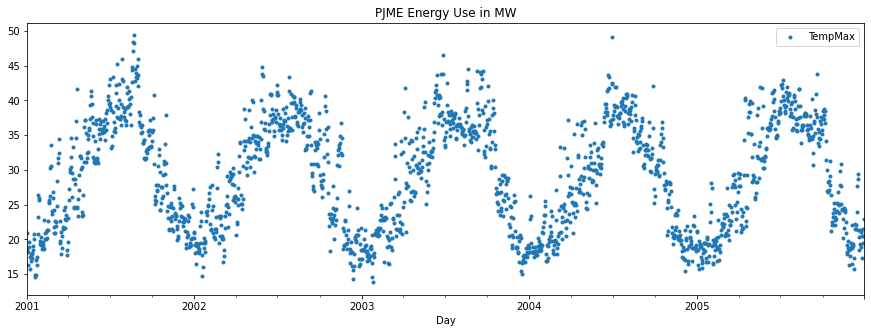

In [281]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

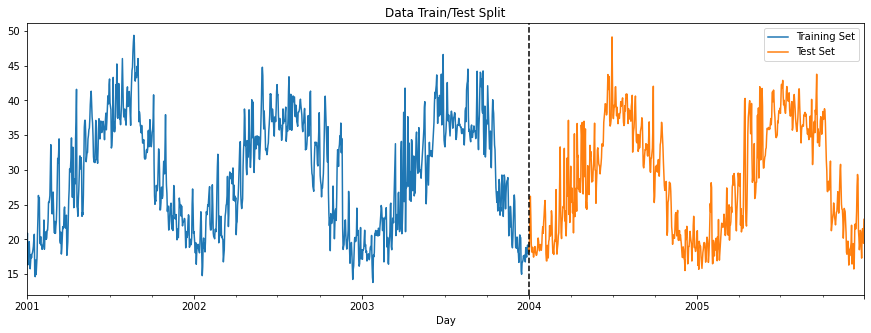

,TempMax
Day,
2001-01-01,18.481531
2001-01-02,20.895227
2001-01-03,16.324121
2001-01-04,18.124323
2001-01-05,18.871942
...,...
2003-12-25,17.744562
2003-12-26,17.449487
2003-12-27,18.175134


In [282]:
train = df.loc[df.index < '12/30/2003']
test = df.loc[df.index >= '12/30/2003']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('12/30/2003', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()
train

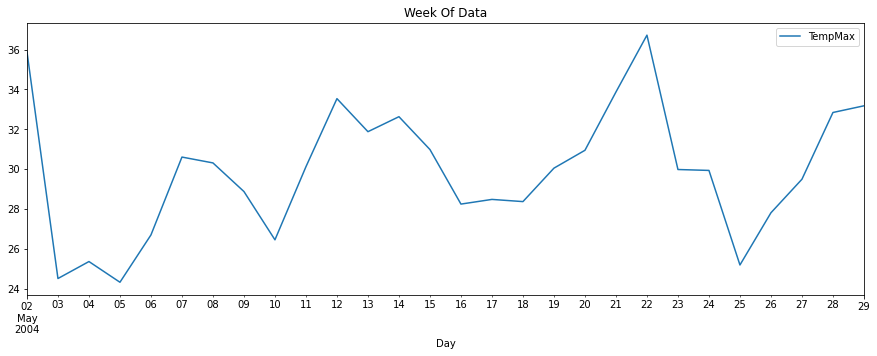

In [283]:
df.loc[(df.index > '05-01-2004') & (df.index < '05-30-2004')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [284]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.week
    
    return df

df = create_features(df)
df

<ipython-input-284-e7c349f90f19>:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['weekofyear'] = df.index.week


,TempMax,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Day,,,,,,,,
2001-01-01,18.481531,0,1,1,2001,1,1,1
2001-01-02,20.895227,1,1,1,2001,2,2,1
2001-01-03,16.324121,2,1,1,2001,3,3,1
2001-01-04,18.124323,3,1,1,2001,4,4,1
2001-01-05,18.871942,4,1,1,2001,5,5,1
...,...,...,...,...,...,...,...,...
2005-12-26,20.483087,0,4,12,2005,360,26,52
2005-12-27,21.541895,1,4,12,2005,361,27,52
2005-12-28,20.531091,2,4,12,2005,362,28,52


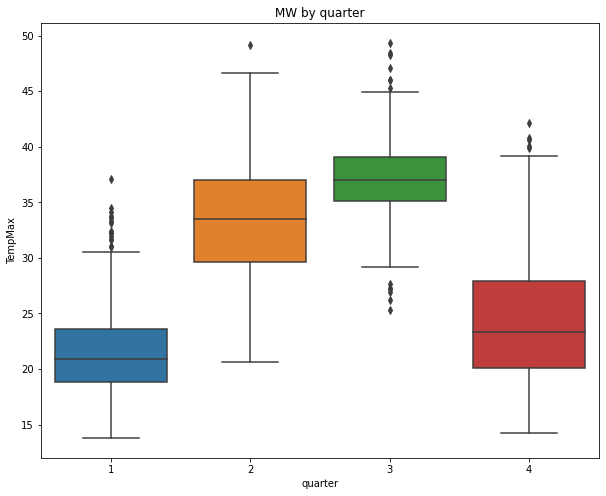

In [285]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='quarter', y='TempMax')
ax.set_title('MW by quarter')
plt.show()

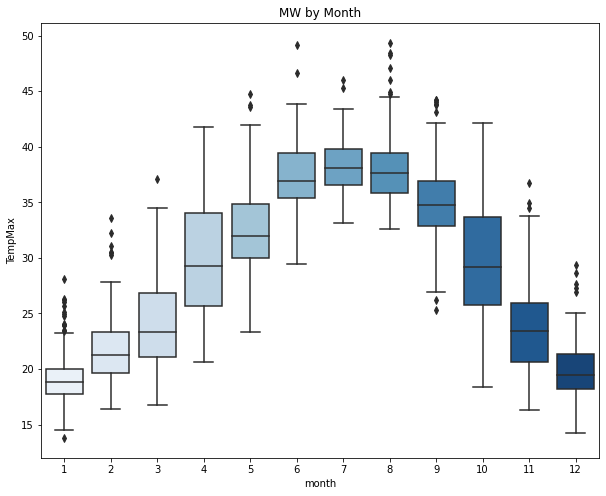

In [286]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='TempMax', palette='Blues')
ax.set_title('MW by Month')
plt.show()

In [321]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear','dayofweek', 'quarter', 'month'] #Giving more features for the model to improve it's training
TARGET = 'TempMax'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

<ipython-input-284-e7c349f90f19>:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['weekofyear'] = df.index.week
<ipython-input-284-e7c349f90f19>:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['weekofyear'] = df.index.week


In [322]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                         max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[19:34:03] WARNING: ..\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:29.73734	validation_1-rmse:28.97556
[100]	validation_0-rmse:11.44806	validation_1-rmse:10.74261
[200]	validation_0-rmse:5.28886	validation_1-rmse:4.78662


D:\conda\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[300]	validation_0-rmse:3.68035	validation_1-rmse:3.56443
[400]	validation_0-rmse:3.36058	validation_1-rmse:3.49746
[500]	validation_0-rmse:3.28683	validation_1-rmse:3.54726
[600]	validation_0-rmse:3.25101	validation_1-rmse:3.58517
[700]	validation_0-rmse:3.22800	validation_1-rmse:3.60993
[800]	validation_0-rmse:3.20999	validation_1-rmse:3.62686
[900]	validation_0-rmse:3.19351	validation_1-rmse:3.64561
[999]	validation_0-rmse:3.17489	validation_1-rmse:3.66477


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

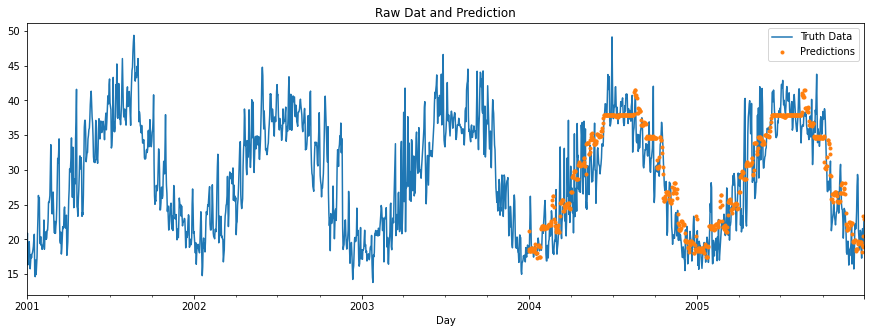

In [323]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['TempMax']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

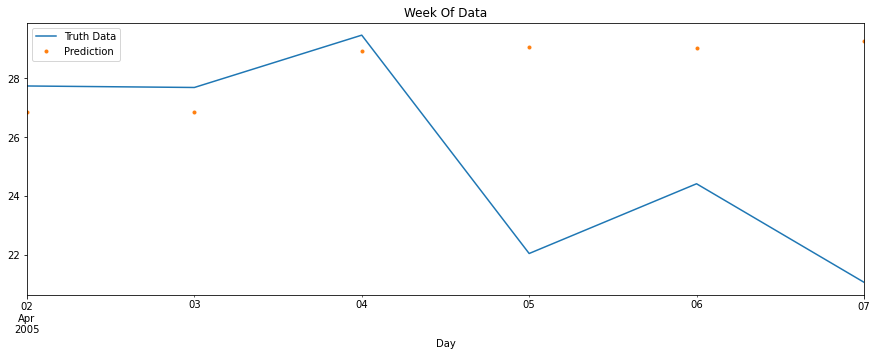

In [324]:
ax = df.loc[(df.index > '04-01-2005') & (df.index < '04-08-2005')]['TempMax'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2005') & (df.index < '04-08-2005')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [342]:
prediction=test['prediction']

In [343]:
test['date']

Day
2003-12-30    2003-12-30
2003-12-31    2003-12-31
2004-01-01    2004-01-01
2004-01-02    2004-01-02
2004-01-03    2004-01-03
                 ...    
2005-12-26    2005-12-26
2005-12-27    2005-12-27
2005-12-28    2005-12-28
2005-12-29    2005-12-29
2005-12-30    2005-12-30
Name: date, Length: 732, dtype: object

In [344]:
# size of the list
import array
size = len(prediction)
big_arr = []
heatwave=[]

# Heatwaves in each correspondent month is 3 or more days with temps more than the avg max temp by 2 degrees
heatwave_temps = {}
heatwave_temps["01"] = 24
heatwave_temps["02"] = 25.6
heatwave_temps["03"] = 28.6
heatwave_temps["04"] = 33
heatwave_temps["05"] = 38.3
heatwave_temps["06"] = 39.7
heatwave_temps["07"] = 40.1
heatwave_temps["08"] = 40
heatwave_temps["09"] = 38.5
heatwave_temps["10"] = 35.1
heatwave_temps["11"] = 30
heatwave_temps["12"] = 25.6

# looping till length - 2
for i in range(size):

    month = test.date[i].strftime("%m")
    # checking the conditions
    if prediction[i] >= heatwave_temps[month] and prediction[i + 1]  >= heatwave_temps[month] and prediction[i + 2] >= heatwave_temps[month]:

        # printing the element as the 
        # conditions are satisfied 
        print('On',test.date[i].strftime("%d"), '/' , test.date[i].strftime("%m"), '/' ,test.date[i].strftime("%Y"),'There will be a Heatwave of ',prediction[i])
        a=prediction[i]
        b=test.date[i]
        heatwave.append(b)
        heatwave.append(a)


        # if test.date[i]
        # print(test.date[i])
        # print('===================flag====================')

On 20 / 02 / 2004 There will be a Heatwave of  25.71376
On 16 / 08 / 2004 There will be a Heatwave of  41.15068
On 17 / 08 / 2004 There will be a Heatwave of  41.446327
On 18 / 08 / 2004 There will be a Heatwave of  41.446327
On 19 / 08 / 2004 There will be a Heatwave of  40.76123
On 20 / 08 / 2004 There will be a Heatwave of  40.717106
On 17 / 08 / 2005 There will be a Heatwave of  41.11752
On 18 / 08 / 2005 There will be a Heatwave of  40.76123
On 19 / 08 / 2005 There will be a Heatwave of  40.717106
On 20 / 08 / 2005 There will be a Heatwave of  40.420265
On 21 / 08 / 2005 There will be a Heatwave of  40.420265
